# Problem 2.9 - Giordano

## Problem statement

Calculate the trajectory of our cannon shell including both air drag and reduced air density at high altitudes so that you can reproduce the results from figure 2.5. Perform your calculations for different firing angles and determine the value of the angle that gives maximum range.

Making use of this equation,

$$F^*_{Drag} = \frac{\rho}{\rho_0} \cdot F_{Drag}$$

in conjunction with

$$\rho = \rho_0 \cdot e^{-\frac{y}{y_0}}$$

I can simplify the computation of drag to

$$F^*_{Drag} = e^{-\frac{y}{y_0}} \cdot F_{Drag}$$

And recall that $F_{Drag} = - B_2 v^2$. Since I have the value of $\frac{B_2}{m} = 4 \cdot 10^{-5} \, \text{m}^{-1}$, I can simply apply these formulae to find acceleration due to drag on the ball and then increment the shell's velocity components accordingly.

$$\vec{a}^*_{Drag} = - \frac{B_2}{m} e^{-\frac{\vec{r} \cdot \hat{y}}{y_0}} \left[ \vec{v} \cdot \vec{v} \right] \hat{v}$$

Finally, we must also include gravity to the overall effective force on the cannon ball. Therefore,

$$\vec{a}_{\text{Net}} = \vec{a}^*_{Drag} - \vec{g}$$

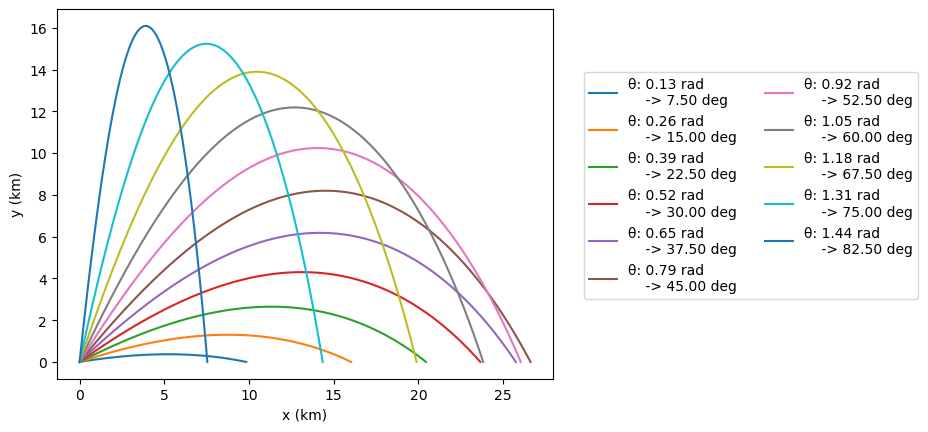

In [5]:
from numpy import array, dot, matmul, exp, sin, cos
from numpy.linalg import norm
from matplotlib.pyplot import plot, show, xlabel, ylabel, legend

# Define constants
B2_m = 4e-5 # 1/m
v0 = 700 # m/s
y0 = 1e4 # m
g = array([[0.0], [-9.8]], float)
y_hat = array([[0.0], [1.0]], float)

# Define number of iterations on angle adjustment
numRotations = 12

# Make a set of labels for the legend based on number of rotations
keys = [
    f"""θ: {3.141592 / (2 * numRotations) * n:.2f} rad
    -> {180.0 / (2 * numRotations) * n:.2f} deg"""
    for n in range(1, numRotations)
]

# Define a step size dθ for each iteration | I add one to denom so that the last iteration is not at π/2 
# avoiding the obvious path (vertical motion)
dθ = 3.141592 / (2 * numRotations)

# Make three lists, one for the time stamps and two for x and y positions
t = [0.0]
x = [0.0]
y = [0.0]

# Define a small time step
dt = 1e-3

# Rotation matrix
R = lambda θ: array([[cos(θ), -sin(θ)], [sin(θ), cos(θ)]], float)

# Define the vectors
v = v0 * array([[1.0], [0.0]], float) # Points in x direction, gets adjusted by rotation matrix
# for initial launch angle
r = array([[0.0], [0.01]], float)

# Define a function to compute the acceleration vector due to drag
a = lambda r, v: - B2_m * exp(- dot(r.T, y_hat).squeeze() / y0) * dot(v.T, v).squeeze() * v / norm(v) + g

# Make another function to rotate v by about 30 degrees
def rotateV(v, θ):
    return matmul(R(θ), v)

# Call once to set the initial launch angle to π/12 radians
v = rotateV(v, dθ)

# Make a function to update the kinematic vectors via euler method
def updateStates(r, v, x, y, t):
    v += a(r, v) * dt
    r += v * dt
    x.append(r[0][0] / 1000.0)
    y.append(r[1][0] / 1000.0)
    t.append(t[-1] + dt)
    return None

# Loop over the functions to create the solutions
for i in range(1, numRotations):
    while r[1] > 0.0:
        updateStates(r, v, x, y, t)
    
    # Plot the results
    plot(x, y)
    
    # Reset the lists
    t = [0.0]
    x = [0.0]
    y = [0.0]
    
    # And reset r and v
    v = v0 * array([[1.0], [0.0]], float) # Points in x direction, 
    # gets adjusted by rotation matrix for initial launch angle
    r = array([[0.0], [0.01]], float)
    
    # Rotate the velocity vector (i + 1) times
    for _ in range(i + 1):
        v = rotateV(v, dθ)

xlabel("x (km)")
ylabel("y (km)")
legend(keys, loc = 1, bbox_to_anchor = (1.75, 0.85), ncol = 2)
show()

## Finding Optimal θ for Maximum Range

To find θ, I make use of Newton's method for honing in on the exact value of θ which yields the largest range. The algorithm is recursive and can be represented by the following.

$$\theta_{i+1} = \theta_i \pm s$$

where the step size, $s$, is either added to or subtracted from θ on each iteration depending on which direction theta should be rotated to increase range. The value of $s$ is then divided by 2 on each iteration to enforce convergence of θ.

In [22]:
# Make a function to reset and return the set of kinematic parameters
def resetValues(θ):
        v = v0 * array([[1.0], [0.0]], float)
        r = array([[0.0], [0.01]], float)
        v = rotateV(v, θ)
        x, y, t = [0.0], [0.01], [0.0]
        
        return r, v, x, y, t

# Newton's method function to find θ for max range with drag and reduced air density
def newtonMethod(θ, dθ, σ):
    rangeMax = 0.0
    rangeLast = 0.0
    rangeNew = 0.0
    
    r, v, x, y, t = resetValues(θ)
    
    difference = σ * 100
    
    while difference >= σ:
        rangeLast = rangeNew
        
        while y[-1] >= 0.0:
            updateStates(r, v, x, y, t)
        
        rangeNew = x[-1]
        
        if rangeNew > rangeMax:
            rangeMax = rangeNew
        
        if rangeNew - rangeLast > 0.0:
            θ += dθ
        elif rangeNew - rangeLast < 0.0:
            θ -= dθ
        else:
            pass
        
        dθ /= 2
        difference = abs(rangeNew - rangeLast)
        r, v, x, y, t = resetValues(θ)
    
    return rangeMax, θ

# Rotate the velocity vector to 45 degrees (Seems close based on the plot above)
θ = 45.0 * 3.141592 / 180.0

# Define a small step size
dθ = 5.0 * 3.141592 / 180.0

# Define a level of accuracy I want
σ = 1e-3

rangeMax, θ_optim = newtonMethod(θ, dθ, σ)

print(f"Max range of the cannon ball is {rangeMax:.3f} km at an angle θ equal to {θ_optim * 180 / 3.141592:.3f} degrees")

Max range of the cannon ball is 26.620 km at an angle θ equal to 49.333 degrees


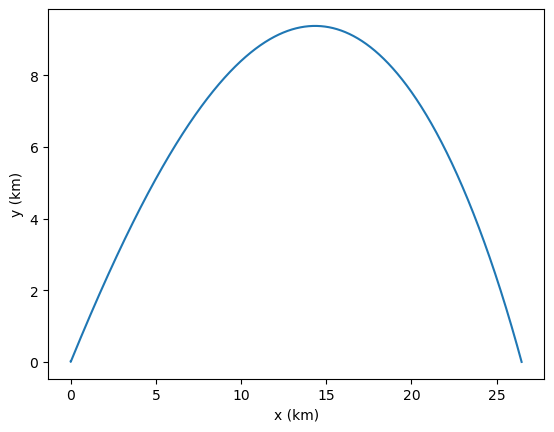

In [23]:
# Get new parameters
r, v, x, y, t = resetValues(θ_optim)

# Plot the max range
while r[1] > 0.0:
    updateStates(r, v, x, y, t)
    
# Plot the results
plot(x, y)
xlabel("x (km)")
ylabel("y (km)")
show()